In [1]:
import pandas as pd
import numpy as np 
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

#### Definitely see the usefulness of classes more now than before.

In [2]:
# Comparison class
class Comparison:
    # __init__ (self, data_tickers)
    # Easier this way
    # Will pull data from either files and/or urls
    def __init__(self, xlsx, csv):
        self.xlsx = xlsx
        self.csv = csv
        
        # File Specific
        #Drops any rows with NaN for clean data
        self.tickers_xlsx = pd.read_excel(self.xlsx, header=4)['Ticker'].dropna(how='any')
        self.tickers_csv = pd.read_csv(self.csv, header=9)['Ticker'].dropna(how='any')
        
        # ticker that contains the assets in the etf
        # Get a mutable list of tickers from the set of each file.
        self.tickers = list(set(self.tickers_xlsx) & set(self.tickers_csv))
    
    # Get Historical Data
    def ticker_history(self, years):
        end = dt.datetime.today()
        start = end - dt.timedelta(days=365*years)
        
        data = yf.download(self.tickers, start=start, end=end)[['Adj Close', 'Volume']].dropna(axis=0, how='all')
        
        base_close = data['Adj Close']
        base_vol = data['Volume']
        
        close = pd.DataFrame()
        vol = pd.DataFrame()
        
        # Drops na values
        for ticker in base_close.columns:
            if base_close[ticker].isna().sum() > 0 :
                base_close.drop(columns=ticker, inplace=True)
                base_vol.drop(columns=ticker, inplace=True)

        return base_close, base_vol

In [3]:
#Trading Algorithm that contains all factors
class Trading_Algo:
    
    #creates variables to use in class
    def __init__(self, close, vol):
        self.price = close
        self.volume = vol
        self.tickers = self.price.columns
        self.pct_return = close.pct_change()
        
        self.slope = pd.DataFrame(index=self.tickers)
        self.vp_slope = pd.DataFrame(index=self.tickers)
        self.factor_agg_df = pd.DataFrame(index=self.tickers)
        
    #returns the trend of each ticker
    def trendline(self):
        for i in range(1,21):
            self.slope[i] = np.polyfit(range(len(self.price[-i - 252: -i])),
                                         self.price[-i - 252: -i], 1)[0]
        return self.slope.mean(axis=1)
    
    #returns the percent above 52 week low
    def above_low(self):
        min = self.price.rolling(260).min()[-20:].mean()
        return ((self.price - min) / min).mean()
    
    #returns the price oscillation based on z score
    def price_osc(self):
        return ((self.price.rolling(20).mean() - self.price.rolling(260).mean()) / self.price.rolling(260).std())[-20:].mean() 
    
    #return the 39 week
    def returns_39w(self):
         return self.price.pct_change(189)[:20].mean()
        
    def vp_trendline(self):
        return (self.pct_return * self.volume).rolling(252).sum()[-20:].mean()
    
    def factor_agg(self):
        self.factor_agg_df['Price Coefficient (Trend)'] = self.trendline()
        self.factor_agg_df['Percent Low'] = self.above_low()
        self.factor_agg_df['Price Oscillator'] = self.price_osc()
        self.factor_agg_df['39 Week Returns'] = self.returns_39w()
        self.factor_agg_df['Volume Price Trend'] = self.vp_trendline()
        
        self.factor_agg_df['Aggregated Z Score'] = (((self.factor_agg_df - self.factor_agg_df.mean()) / self.factor_agg_df.std())).sum(axis=1)
        
        return self.factor_agg_df['Aggregated Z Score'].nlargest(15), self.factor_agg_df['Aggregated Z Score'].nsmallest(15)

In [4]:
# Apparently simply using the urls is generally better. 
# Switched from OEF to XLY ETF Ticker

# XLSX must be INTERMEDIARY
# Using sites other than ssga breaks because of the need to edit the excel files

xlsx = 'https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spyg.xlsx'
csv = 'https://www.blackrock.com/us/individual/products/239726/ishares-core-sp-500-etf/1464253357814.ajax?fileType=csv&fileName=IVV_holdings&dataType=fund'


In [5]:
# Enables comparison between ETF and Portfolio thanks to assigning class

etf = Comparison(xlsx, csv)


In [6]:
type(etf)

__main__.Comparison

In [7]:
# Getting 5 years of ETF data
years = 5
close, vol = etf.ticker_history(years) # Works because etf is now Market class. 
# Still get this same error (doesn't impact)

[*********************100%***********************]  239 of 239 completed


C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
close == vol

,A,AAP,AAPL,ABBV,ABMD,ABT,ACN,ADBE,ADP,ADSK,...,WAT,WM,WST,WY,XLNX,XYL,YUM,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-28,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-12-29,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-12-30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2017-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2017-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-12-20,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-12-21,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
# Actual Date Range
end = dt.datetime.today() - dt.timedelta(days=20) #20 Day Lag
start = end - dt.timedelta(days=365*3.5)
my_dates = pd.date_range(start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), freq='M')

In [10]:
# Get monthly returns
# Pct_Change()
monthly_return = close[:-20].pct_change().resample('m').sum()

In [11]:
# Dataframes for portfolio and baskets.
# Remember close.columns = your tickers.
# Makes it easy.
portfolio = pd.DataFrame(index=my_dates, columns=close.columns)
                         
short_positons = pd.DataFrame(index=my_dates, columns=close.columns)
long_positions = pd.DataFrame(index=my_dates, columns=close.columns)

In [12]:
for my_date in my_dates:
    
    algo = Trading_Algo(close[close.index < my_date], vol[vol.index < my_date]) 
    best, worst = algo.factor_agg()
    
    for b_index in best.index:
        portfolio[b_index].iloc[portfolio.index==my_date] = '1'
        long_positions[b_index].iloc[portfolio.index==my_date] =  '1'
    for w_index in worst.index:
        portfolio[w_index].iloc[portfolio.index==my_date] = '-1'
        short_positons[w_index].iloc[portfolio.index==my_date] = '-1' 

# Need to get rid of na values
# "Only the stocks the algorithm picks"
portfolio.fillna('0', inplace=True)
short_positons.fillna('0', inplace=True)
long_positions.fillna('0', inplace=True)

In [13]:
# "Multiply each data frame with monthly return to get returns of portfolio and baskets"
returns = pd.DataFrame((monthly_return * portfolio.astype(int)).mean(axis=1)).dropna()

short_returns = pd.DataFrame((monthly_return * short_positons.astype(int)).mean(axis=1)).dropna()
long_returns = pd.DataFrame((monthly_return * long_positions.astype(int)).mean(axis=1)).dropna()


In [14]:
# ETF Monthly Return 
etf_returns = pd.DataFrame(monthly_return[monthly_return.index > start].mean(axis=1))


In [15]:
# The DIFFERENCE between port/basket and the etf.
portfolio_vs_etf = pd.DataFrame(returns[0] - etf_returns[0]).dropna()
long_vs_etf = pd.DataFrame(long_returns[0] - etf_returns[0]).dropna()
short_vs_etf = pd.DataFrame(short_returns[0] - etf_returns[0]).dropna()

In [16]:
# Cumulative returns
# cumsum() makes it easy
# Search up log1p

returns['cum_ret'] = np.exp(np.log1p(returns).cumsum())

short_returns['cum_ret'] = np.exp(np.log1p(short_returns).cumsum())
long_returns['cum_ret'] = np.exp(np.log1p(long_returns).cumsum())



In [17]:
# Cumulative return of ETF
etf_returns['cum_ret'] = np.exp(np.log1p(etf_returns.mean(axis=1)).cumsum())

In [18]:
# Determines colors based on positive or negative values
# Portfolio return vs ETF
portfolio_vs_etf['Positive'] = (portfolio_vs_etf[0] > 0)

In [19]:
#port_v_etf.head()

## Plotting

<AxesSubplot:title={'center':'Monthly Returns of Portfolio vs ETF'}, xlabel='Dates by Month', ylabel='Return (Convert to %)'>

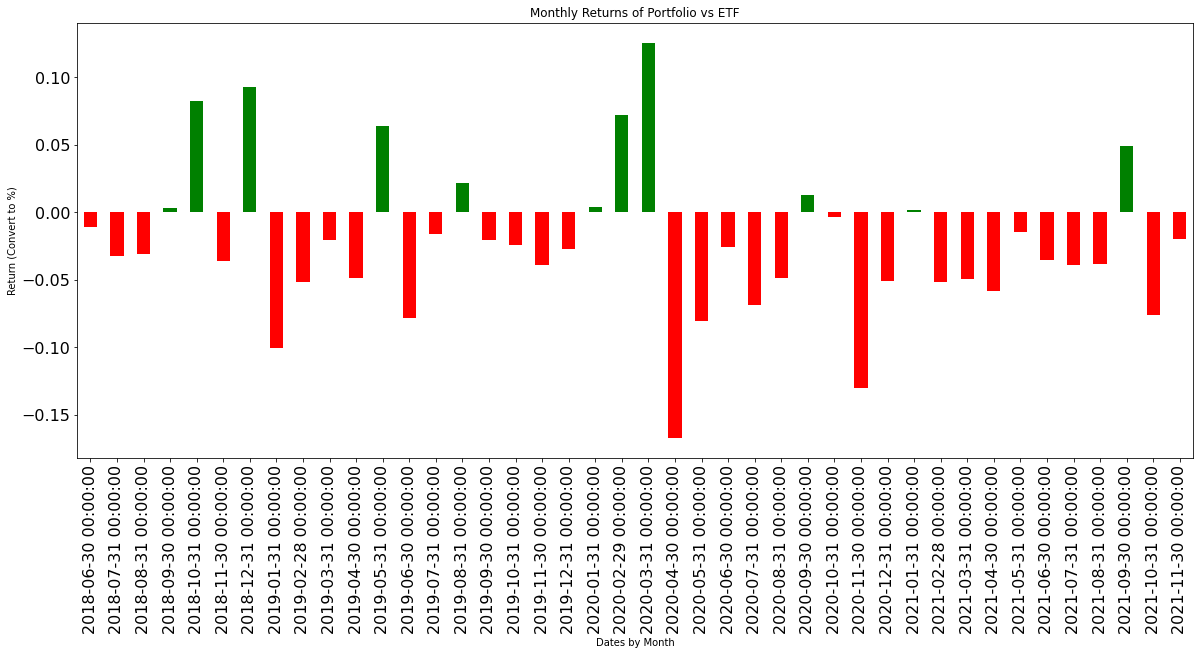

In [20]:
# Algorithm returns
portfolio_vs_etf[0].plot(kind='bar',
                   fontsize=16,
                   figsize=(20,8),
                   title='Monthly Returns of Portfolio vs ETF',
                   xlabel='Dates by Month',
                   ylabel='Return (Convert to %)',
                   color=['g' if i == True else 'r' for i in portfolio_vs_etf['Positive']])
#portfolio_vs_etf.plt.grid()

#### Basket Comparison
##### Long vs Short

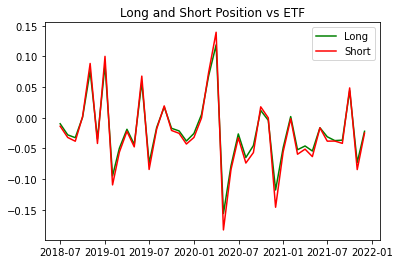

In [21]:
# IT's that simple...
# Basket comparison
plt.title('Long and Short Position vs ETF')

# Long = green
# Short = red
plt.plot(long_vs_etf, color='g',label='Long')
plt.plot(short_vs_etf, color='r',label='Short')
plt.legend()

#### Cumulative Portfolio Return

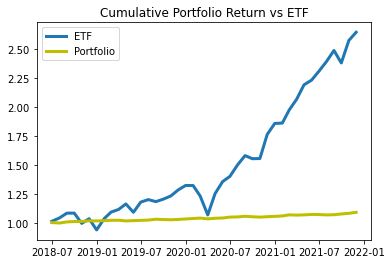

In [22]:
# Cumulative Portfolio Return
# Can't increase figsize on plot?

plt.title('Cumulative Portfolio Return vs ETF')
plt.plot(etf_returns.cum_ret,linewidth=3, label='ETF') #Blue Line = ETF Return

plt.plot(returns.cum_ret,linewidth=3,color='y',label='Portfolio') #Yellow Line = Portfolio Return
plt.legend()

#Uptrend but can't increase figure size